<a href="https://colab.research.google.com/github/Chdunham/Chdunham.github.io/blob/master/Encoder_Decoder_on_Adult_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this post, we will see how to generate tabular synthetic data using Generative adversarial networks(GANs). The goal is to generate synthetic data that is similar to the actual data in terms of statistics and demographics. 

## Introduction

It is important to ensure data privacy while publicly sharing information that contains sensitive information. There are numerous ways to tackle it and in this post we will use neural networks to generate synthetic data whose statistical features match the actual data. 

We would be working with the Synthea dataset which is publicly available. Using the patients data from this dataset, we will try to generate synthetic data. 

https://synthetichealth.github.io/synthea/

In [134]:
#!rm model/*

## Data Preprocessing



Firstly, download the publicly available adult dataset and unzip it. 

In [135]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
tf.__version__

# Source: https://fairmlbook.org/code/adult.html

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

original_train = original_train.dropna()
original_test = original_test.dropna()

original = pd.concat([original_test, original_train])

original['Target'] = original['Target'].replace('<=50K', '<=50K').replace('>50K', '>50K')
original['Target'] = original['Target'].replace('<=50K.', '<=50K').replace('>50K.', '>50K')

original.name = 'AdultDataCombined'
original.csv_path = 'AdultDataCombined.csv'

print(original)

original.to_csv(original.csv_path)

       Age     Workclass  fnlwgt  ... Hours per week        Country Target
0       25       Private  226802  ...             40  United-States  <=50K
1       38       Private   89814  ...             50  United-States  <=50K
2       28     Local-gov  336951  ...             40  United-States   >50K
3       44       Private  160323  ...             40  United-States   >50K
5       34       Private  198693  ...             30  United-States  <=50K
...    ...           ...     ...  ...            ...            ...    ...
32556   27       Private  257302  ...             38  United-States  <=50K
32557   40       Private  154374  ...             40  United-States   >50K
32558   58       Private  151910  ...             40  United-States  <=50K
32559   22       Private  201490  ...             20  United-States  <=50K
32560   52  Self-emp-inc  287927  ...             40  United-States   >50K

[45222 rows x 15 columns]


In [136]:
import pandas as pd

df = pd.read_csv('AdultDataCombined.csv')
df.drop(['Unnamed: 0','fnlwgt','Education-Num'], axis=1, inplace=True)
print(df.columns)

Index(['Age', 'Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country', 'Target'],
      dtype='object')


### Remove unnecessary columns and encode all data

In [137]:
df = original
#df.drop(['Unnamed: 0','fnlwgt','Education-Num'], axis=1, inplace=True)
print(df.columns)

Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'],
      dtype='object')


Next, read patients data and remove fields such as id, date, SSN, name etc. Note, that we are trying to generate synthetic data which can be used to train our deep learning models for some other tasks. For such a model, we don't require fields like id, date, SSN etc. 

In [138]:
# data configuration
file_name = "AdultDataCombined.csv"
columns_to_drop = ['fnlwgt','Education-Num']
columns_to_drop = ['Unnamed: 0','fnlwgt','Education-Num']

categorical_features = ['Workclass', 'Education', 'Martial Status', 'Occupation', 'Country','Relationship', 'Race', 'Sex', 'Target']
continuous_features = ['Age','Capital Gain', 'Capital Loss', 'Hours per week']
col1, col2 = 'Sex', 'Sex'
col_group_by = 'Target'

# training configuration
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 15000+1
learning_rate = 5e-4
models_dir = 'model'

In [139]:
import pandas as pd

df = pd.read_csv(file_name)
df.drop(columns_to_drop, axis=1, inplace=True)
print(df.columns)

Index(['Age', 'Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country', 'Target'],
      dtype='object')


Next, we will encode all [categorical features](https://en.wikipedia.org/wiki/Categorical_variable) to integer values. We are simply encoding the features to numerical values and are not using one hot encoding as its not required for GANs. 

In [140]:
for column in categorical_features:
  df[column] = df[column].astype('category').cat.codes

df.head()

,Age,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,2,1,4,6,3,2,1,0,0,40,38,0
1,38,2,11,2,4,0,4,1,0,0,50,38,0
2,28,1,7,2,10,0,4,1,0,0,40,38,1
3,44,2,15,2,6,0,2,1,7688,0,40,38,1
4,34,2,0,4,7,1,4,1,0,0,30,38,0


Next, we will encode all [continious features](https://en.wikipedia.org/wiki/Continuous_or_discrete_variable?oldformat=true) to equally sized bins. First, lets find the minimum and maximum values for `HEALTHCARE_EXPENSES` and `HEALTHCARE_COVERAGE` and then create bins based on these values. 

In [141]:
import numpy as np

for column in continuous_features:
  min = df[column].min()
  max = df[column].max()
  feature_bins = pd.cut(df[column], bins=21, labels=False)
  print(feature_bins)
  df.drop([column], axis=1, inplace=True)
  df = pd.concat([df, feature_bins], axis=1)
df

0         2
1         6
2         3
3         7
4         4
         ..
45217     2
45218     6
45219    11
45220     1
45221    10
Name: Age, Length: 45222, dtype: int64
0        0
1        0
2        0
3        1
4        0
        ..
45217    0
45218    0
45219    0
45220    0
45221    3
Name: Capital Gain, Length: 45222, dtype: int64
0        0
1        0
2        0
3        0
4        0
        ..
45217    0
45218    0
45219    0
45220    0
45221    0
Name: Capital Loss, Length: 45222, dtype: int64
0         8
1        10
2         8
3         8
4         6
         ..
45217     7
45218     8
45219     8
45220     4
45221     8
Name: Hours per week, Length: 45222, dtype: int64


,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Target,Age,Capital Gain,Capital Loss,Hours per week
0,2,1,4,6,3,2,1,38,0,2,0,0,8
1,2,11,2,4,0,4,1,38,0,6,0,0,10
2,1,7,2,10,0,4,1,38,1,3,0,0,8
3,2,15,2,6,0,2,1,38,1,7,1,0,8
4,2,0,4,7,1,4,1,38,0,4,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,2,7,2,12,5,4,0,38,0,2,0,0,7
45218,2,11,2,6,0,4,1,38,1,6,0,0,8
45219,2,11,6,0,4,4,0,38,0,11,0,0,8
45220,2,11,4,0,3,4,1,38,0,1,0,0,4


### Transform the data

Next, we apply `PowerTransformer` on all the fields to get a Gaussian distribution for the data. 

In [142]:
# from sklearn.preprocessing import PowerTransformer


# df[df.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(df[df.columns])

# print(df)

In [143]:
from sklearn.preprocessing import PowerTransformer


pw= PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
pwt=pw.fit_transform(df[df.columns])

print(df)

       Workclass  Education  ...  Capital Loss  Hours per week
0              2          1  ...             0               8
1              2         11  ...             0              10
2              1          7  ...             0               8
3              2         15  ...             0               8
4              2          0  ...             0               6
...          ...        ...  ...           ...             ...
45217          2          7  ...             0               7
45218          2         11  ...             0               8
45219          2         11  ...             0               8
45220          2         11  ...             0               4
45221          3         11  ...             0               8

[45222 rows x 13 columns]


In [144]:
df[df.columns]=pwt

name = 'Target'
TARGET_COL_INDEX = 8
GENDER_COL_INDEX = 6

In [145]:
df

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Target,Age,Capital Gain,Capital Loss,Hours per week
0,-0.135874,-2.087375,0.940015,0.129222,1.115194,-2.491555,0.693813,0.296563,-0.574031,-0.979926,-0.237261,-0.222819,-0.060155
1,-0.135874,0.088504,-0.365603,-0.366076,-1.082369,0.402923,0.693813,0.296563,-0.574031,0.213442,-0.237261,-0.222819,0.739046
2,-1.373407,-1.000172,-0.365603,0.982199,-1.082369,0.402923,0.693813,0.296563,1.742067,-0.631727,-0.237261,-0.222819,-0.060155
3,-0.135874,1.406773,-0.365603,0.129222,-1.082369,-2.491555,0.693813,0.296563,1.742067,0.453851,4.214746,-0.222819,-0.060155
4,-0.135874,-2.180048,0.940015,0.356604,0.170825,0.402923,0.693813,0.296563,-0.574031,-0.323670,-0.237261,-0.222819,-0.851784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,-0.135874,-1.000172,-0.365603,1.363811,1.555688,0.402923,-1.441310,0.296563,-0.574031,-0.979926,-0.237261,-0.222819,-0.457023
45218,-0.135874,0.088504,-0.365603,0.129222,-1.082369,0.402923,0.693813,0.296563,1.742067,0.213442,-0.237261,-0.222819,-0.060155
45219,-0.135874,0.088504,2.191223,-1.706791,1.366606,0.402923,-1.441310,0.296563,-0.574031,1.294236,-0.237261,-0.222819,-0.060155
45220,-0.135874,0.088504,0.940015,-1.706791,1.115194,0.402923,0.693813,0.296563,-0.574031,-1.390624,-0.237261,-0.222819,-1.633730


## Train the Model

Next, lets define the neural network for generating synthetic data. We will be using a [GAN](https://www.wikiwand.com/en/Generative_adversarial_network) network that comprises of an generator and discriminator that tries to beat each other and in the process learns the vector embedding for the data. 

The model was taken from a [Github repository](https://github.com/ydataai/gan-playground) where it is used to generate synthetic data on credit card fraud data. 

In [146]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args
        print(1)

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)
        print(2)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)
        print(3)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        print(4)

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        y = Input(shape=(1,))
        s = Input(shape=(1,))
        record = self.generator([z, y, s])

        print(5)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        print(6)

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)
        print(7)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([z,y,s], validity)
        print(8)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        print(9)
    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            #print(batch_data)
            # TODO: fix bad code
            labelsTarget = batch_data[:,TARGET_COL_INDEX]
            labelsGender = batch_data[:,GENDER_COL_INDEX]
            #print("labels created")

            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Generate a batch of new images
            gen_data = self.generator.predict([noise, labelsTarget, labelsGender])
            #print("Noise and gen_data")
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch([noise, labelsTarget, labelsGender], valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator([z, np.zeros((432, )), np.zeros((432, ))])
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        inputIncome= Input(shape=(1,), batch_size=self.batch_size)
        inputGender= Input(shape=(1,), batch_size=self.batch_size)
        t = Dense(dim, activation='relu')(input)
        y = Dense(dim, activation='relu')(inputIncome)
        s = Dense(dim, activation='relu')(inputGender)
        x = Concatenate(axis=1)([t, y, s])
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=[input,inputIncome,inputGender], outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

Next, lets define the training parameters for the GAN network. We would be using a batch size of 32 and train it for 5000 epochs.

In [147]:
data_cols = df.columns

In [148]:
#Define the GAN and training parameters
df[data_cols] = df[data_cols]

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

13


In [149]:
!mkdir model
!mkdir model/gan
!mkdir model/gan/saved

mkdir: cannot create directory ‘model’: File exists
mkdir: cannot create directory ‘model/gan’: File exists
mkdir: cannot create directory ‘model/gan/saved’: File exists


Finally, let's run the training and see if the model is able to learn something. 

In [150]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
print(synthesizer)
synthesizer.train(df, train_args)

Streaming output truncated to the last 5000 lines.
10051 [D loss: 0.211399, acc.: 92.19%] [G loss: 3.027591]
10052 [D loss: 0.208078, acc.: 92.19%] [G loss: 3.062496]
10053 [D loss: 0.215799, acc.: 92.19%] [G loss: 2.295818]
10054 [D loss: 0.234860, acc.: 92.19%] [G loss: 2.330692]
10055 [D loss: 0.221753, acc.: 92.19%] [G loss: 2.500535]
10056 [D loss: 0.216345, acc.: 92.19%] [G loss: 2.256516]
10057 [D loss: 0.223655, acc.: 92.19%] [G loss: 2.322309]
10058 [D loss: 0.212366, acc.: 92.19%] [G loss: 2.665014]
10059 [D loss: 0.221789, acc.: 92.19%] [G loss: 2.273906]
10060 [D loss: 0.218148, acc.: 92.19%] [G loss: 2.448013]
10061 [D loss: 0.226688, acc.: 92.19%] [G loss: 2.123558]
10062 [D loss: 0.207230, acc.: 92.19%] [G loss: 2.603240]
10063 [D loss: 0.220019, acc.: 92.19%] [G loss: 2.590514]
10064 [D loss: 0.216327, acc.: 92.19%] [G loss: 2.185410]
10065 [D loss: 0.215382, acc.: 92.19%] [G loss: 2.093946]
10066 [D loss: 0.220197, acc.: 92.19%] [G loss: 2.172006]
10067 [D loss: 0.2290

After, 5000 epochs the models shows a training accuracy of 95.31% which sounds quite impressive. 

In [151]:
!mkdir model/gan

mkdir: cannot create directory ‘model/gan’: File exists


In [152]:
#You can easily save the trained generator and loaded it aftwerwards

synthesizer.save('model/gan/saved', 'generator_patients')

Let's take a look at the Generator and Discriminator models. 

In [153]:
synthesizer.generator.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(32, 32)]           0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(32, 1)]            0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(32, 1)]            0                                            
__________________________________________________________________________________________________
dense_50 (Dense)                (32, 128)            4224        input_36[0][0]                   
___________________________________________________________________________________________

In [154]:
synthesizer.discriminator.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(32, 13)]                0         
_________________________________________________________________
dense_56 (Dense)             (32, 512)                 7168      
_________________________________________________________________
dropout_10 (Dropout)         (32, 512)                 0         
_________________________________________________________________
dense_57 (Dense)             (32, 256)                 131328    
_________________________________________________________________
dropout_11 (Dropout)         (32, 256)                 0         
_________________________________________________________________
dense_58 (Dense)             (32, 128)                 32896     
_________________________________________________________________
dense_59 (Dense)             (32, 1)                   129

## Evaluation

Now, that we have trained the model let's see if the generated data is similar to the actual data. 

We plot the generated data for some of the model steps and see how the plot for the generated data changes as the networks learns the embedding more accurately. 

In [155]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


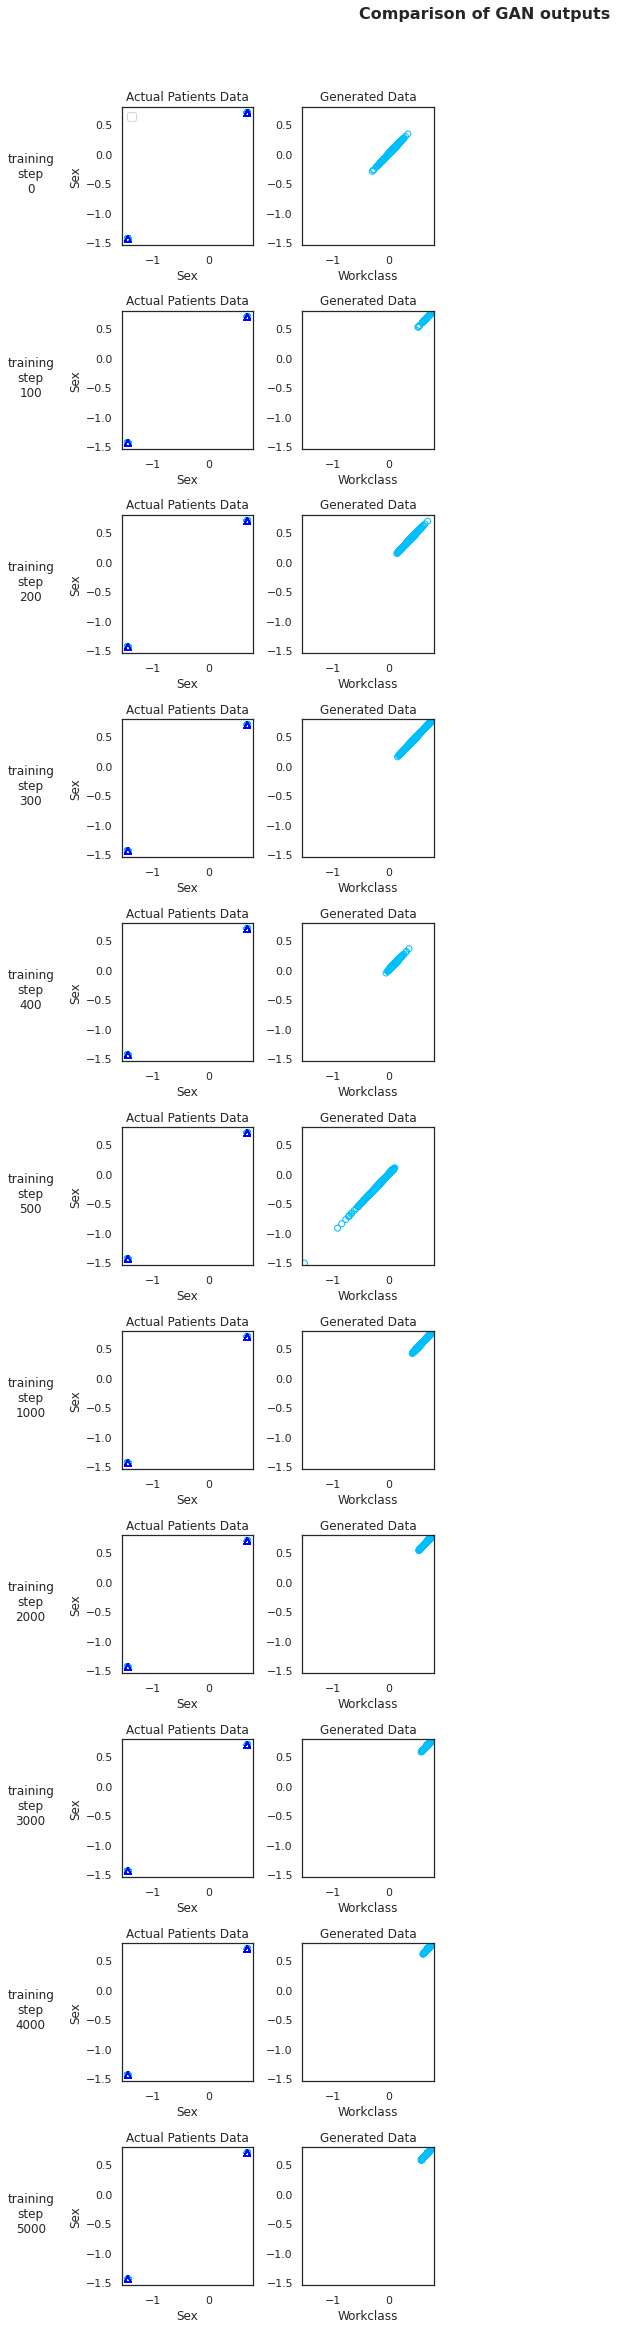

In [156]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 1000 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
y = np.random.random_integers(0, 1,test_size)
s = np.random.random_integers(0, 1,test_size)

real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby(col_group_by), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Patients Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict([z, y, s])

    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [157]:
# g_z=pw.inverse_transform(g_z)
# gen_samples = pd.DataFrame(g_z, columns=data_cols)
# gen_samples.to_csv('Generated_sample.csv')

In [158]:

gen_samples[:50]

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Target,Age,Capital Gain,Capital Loss,Hours per week
0,-0.111212,-1.848074,0.881859,0.320421,1.049901,0.396988,0.666851,0.280879,-0.540483,-1.801825,-0.224503,-0.223435,-0.435001
1,-0.141188,-2.165355,-0.347652,-0.943083,-1.075307,0.411782,0.681953,0.291526,-0.559587,0.671941,-0.241609,-0.222743,-0.052630
2,-0.121167,-1.841314,0.863089,0.288167,1.032197,0.392914,0.662616,0.270698,-0.528185,-1.792714,-0.219291,-0.220638,-0.432395
3,-0.144349,-2.176023,-0.350662,-0.948006,-1.082926,0.414230,0.684586,0.291498,-0.566932,0.673359,-0.241418,-0.223451,-0.053405
4,-0.140951,-2.153721,-0.343912,-0.936167,-1.068819,0.409918,0.679238,0.290199,-0.556046,0.666617,-0.240120,-0.221599,-0.051393
5,-0.132938,-0.485522,0.938948,-0.126210,1.107851,0.408887,0.688918,0.293559,-0.576405,-0.605794,-0.239367,-0.221651,-0.058829
6,-0.140221,0.087002,0.928924,-0.941787,0.179022,0.406491,0.677210,0.276198,-0.555728,-0.615510,-0.224650,-0.224571,0.714696
7,-0.136942,0.081926,0.947853,-0.946917,0.187447,0.404789,0.687975,0.286013,-0.566061,-0.632415,-0.232883,-0.224310,0.726933
8,-0.129004,-0.480264,0.923437,-0.112534,1.093010,0.401649,0.679754,0.284823,-0.560549,-0.613821,-0.230230,-0.218628,-0.069011
9,-0.129560,0.060223,0.938234,-0.904705,0.221625,0.401481,0.680986,0.289556,-0.562318,-0.615742,-0.225283,-0.222665,0.685041


Now let's try to do a feature by feature comparision between the generated data and the actual data. We will use python's `table_evaluator` library to compare the features. 

In [159]:
!pip install table_evaluator


In [160]:
#gen_samples.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_samples.columns)
#print(df.shape, gen_df.shape)

Index(['Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Country', 'Target', 'Age',
       'Capital Gain', 'Capital Loss', 'Hours per week'],
      dtype='object')


We call the `visual_evaluation` method to compare the actual date(`df`) and the generated data(`gen_df`).

45222 1000


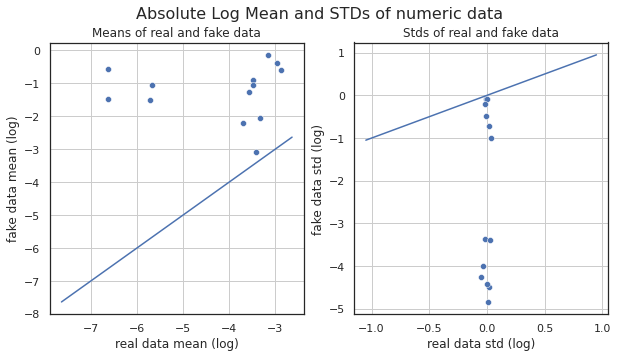

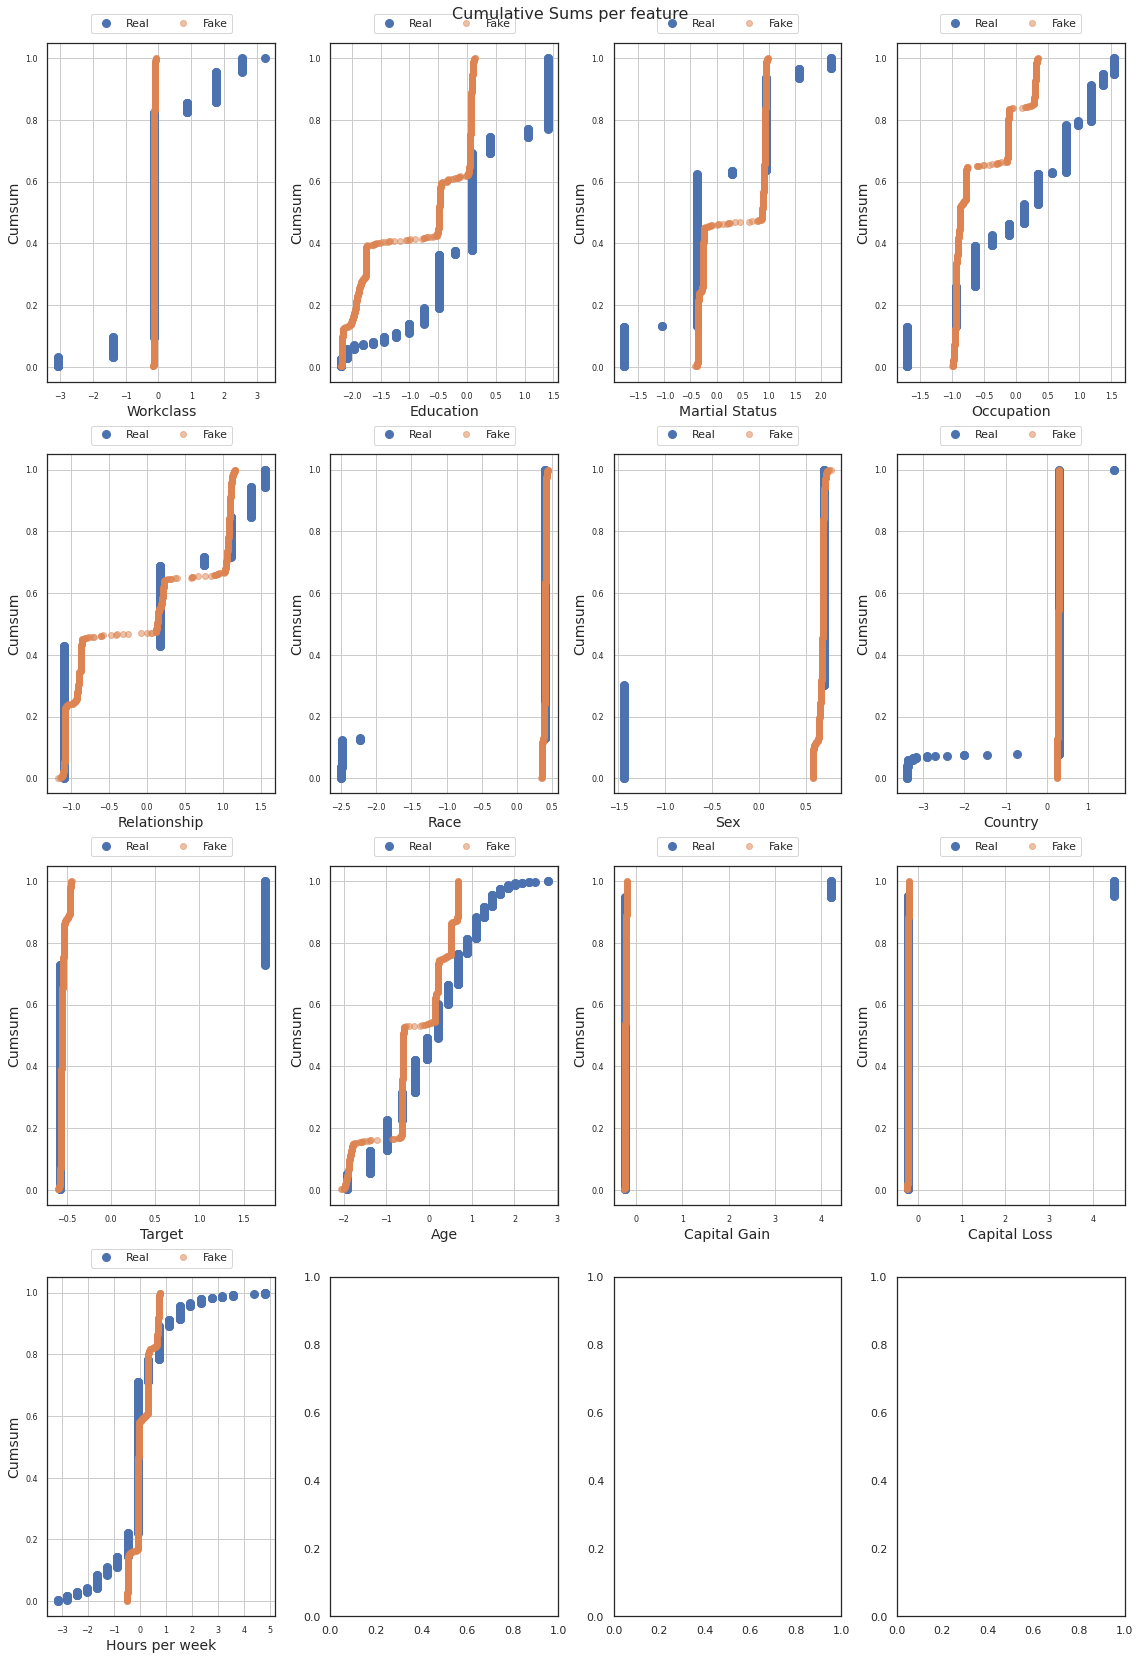

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

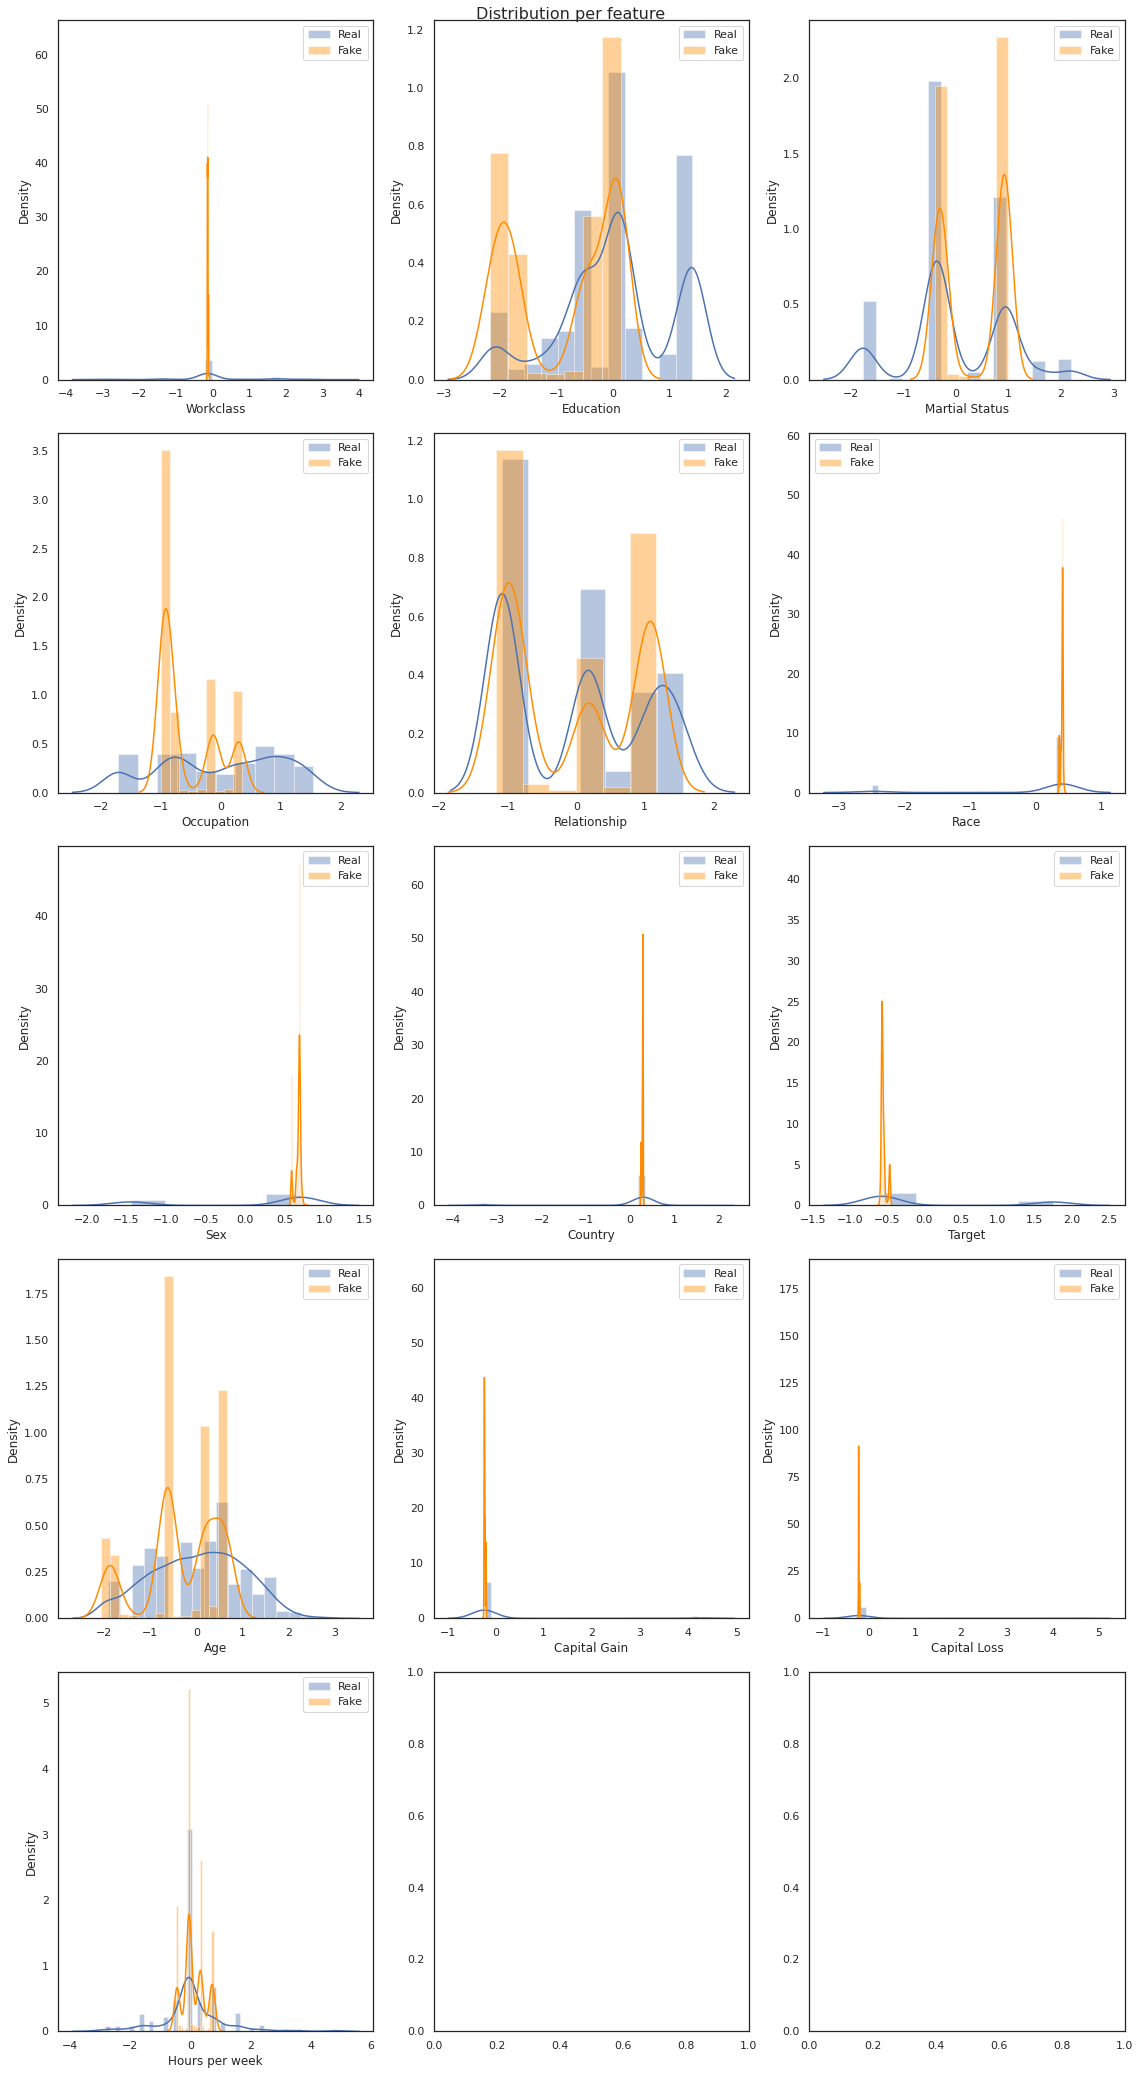

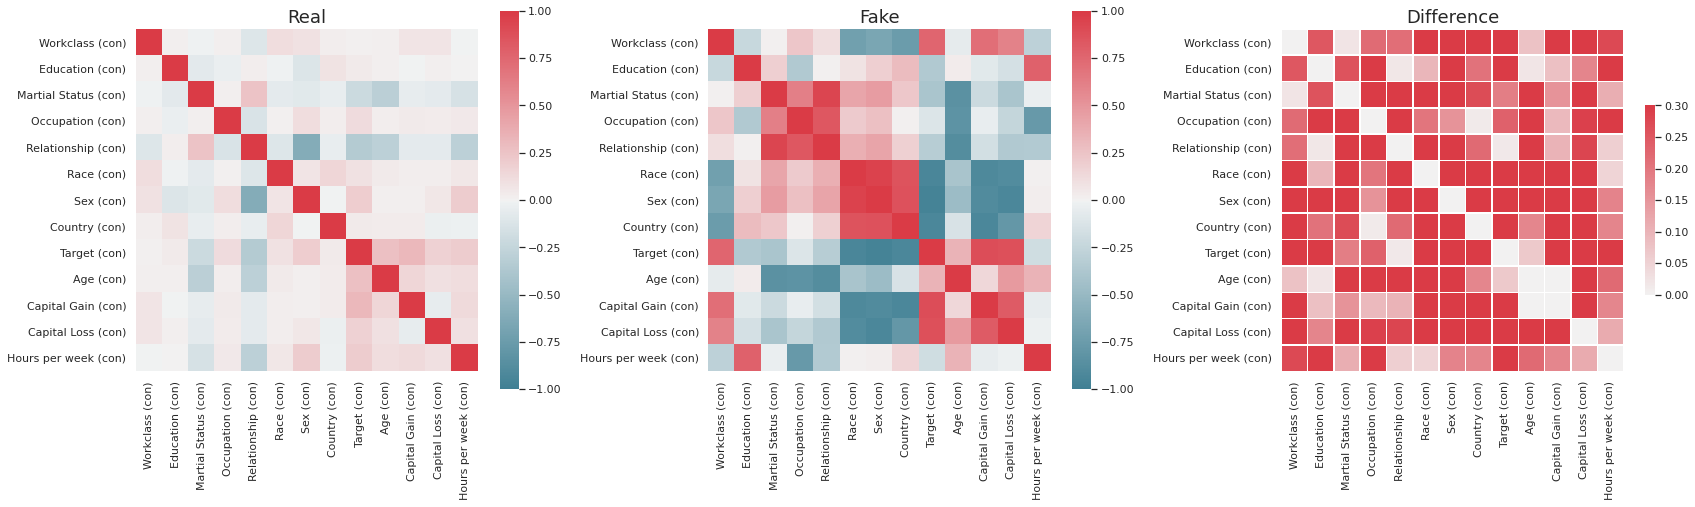

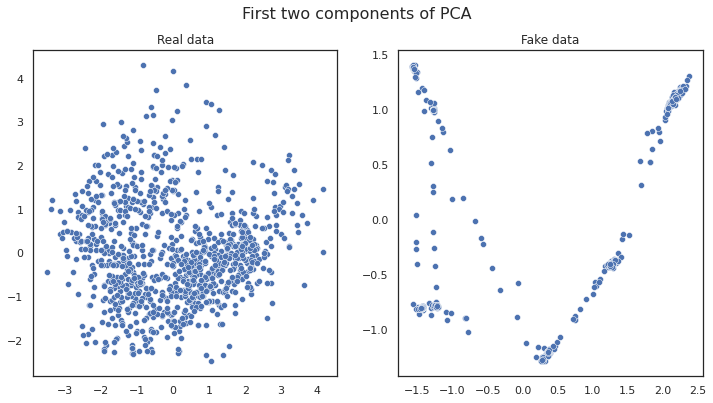

In [161]:
from table_evaluator import load_data, TableEvaluator

print(len(df), len(gen_samples))
#print(fake.columns, real.columns)
table_evaluator =  TableEvaluator(df, gen_samples)

table_evaluator.visual_evaluation()

 ## Conclusion

Some of the features in the syntehtic data match closely with actual data but there are some other features which were not learnt perfectly by the model. We can keep playing with the model and its hyperparameters to improve the model further. 

This post demonstrates that its fairly simply to use GANs to generate synthetic data where the actual data is sensitive in nature and can't be shared publicly. 